In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sys
from ldstack import *

## Building and importing ``linear_recurrence``



The parallel GPU implementation of ``linear_recurrence`` is reasonably fast, but is a custom CUDA op. It is originally based on [Martin and Cundy's code](https://github.com/eamartin/parallelizing_linear_rnns). We adapt it to support complex numbers, TensorFlow 2, and sparse input sequences. 

To build on TensorFlow 2.3, run the following commands first.

In [ ]:
!mkdir -p /usr/local/lib/python3.6/dist-packages/tensorflow/include/tensorflow/core/util/third_party/gpus/cuda
!ln -s /usr/local/cuda/include /usr/local/lib/python3.6/dist-packages/tensorflow/include/tensorflow/core/util/third_party/gpus/cuda/include 
!cd linear_recurrent_net && bash build.sh

Now import.

In [ ]:
sys.path.append('./linear_recurrent_net')
from linear_recurrent_net.linear_recurrent_net.tensorflow_binding import linear_recurrence, sparse_linear_recurrence, linear_recurrence_cpu

# Experiment: Copying Memory Problem 

In [ ]:
from IPython.display import clear_output
# updatable plot
# a minimal example (sort of)

all_losses = []

class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.x = []
        self.losses = []
        self.fig = plt.figure()
        
    def on_epoch_end(self, epoch, logs={}):
        self.x.append(epoch)
        self.losses.append(logs.get('loss'))
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.legend()
        plt.show();
    
    def on_train_end(self, logs=None):
        all_losses.append(self.losses)

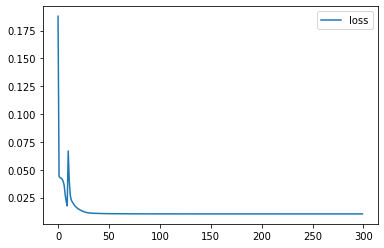

39/39 [==============================] - 6s 155ms/step - loss: 0.0103


In [ ]:
all_losses = []
num_samples = 10000
T = 2000
batch_size = 256
# 0 is blank, 1-8 are content, 9 is delimiter
X = np.zeros((num_samples, T+20), dtype=np.float32)
answers = np.random.randint(low = 1, high = 9, size = (num_samples, 10))
X[:, :10] = answers
X[:, -11] = 9
Y = np.zeros((num_samples, T+20), dtype=np.int64)
Y[:, -10:] = X[:, :10]
# [num_samples, T, 20]
X = tf.one_hot(X, depth=10)
dataset = tf.data.Dataset.from_tensor_slices((X,Y)).batch(batch_size, drop_remainder=True)

# Network Parameters
learning_rate = 0.01
num_classes = 10
n_lds = 160
n_srnn = 80
n_lstm = 40
num_epochs = 300

srnn = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(n_srnn, kernel_initializer=tf.keras.initializers.Orthogonal(), return_sequences=True, activation='tanh'),
  tf.keras.layers.Dense(num_classes)                       
])
srnn.build(input_shape=(batch_size, T+20, 10))
srnn_optimizer = tf.keras.optimizers.Adamax(learning_rate)
srnn.summary()

lds = tf.keras.Sequential([                      
  LuenbergerStack(n_lds, num_classes, 1, AB_param=unitary_AB_param(), C_param=relaxed_log_C_param(), D_param=standard_D_param(useD=False), mode='naive'),
])
lds.build(input_shape=(batch_size, T+20, 10))
lds_optimizer = tf.keras.optimizers.Adamax(learning_rate)
lds.summary()

#ldstack = tf.keras.Sequential([                      
#  LuenbergerStack(n_lds, num_classes, 2, AB_param=unitary_AB_param(), C_param=relaxed_log_C_param(0.1), D_param=standard_D_param(useD=False), mode='naive'),
#])
#ldstack.build(input_shape=(batch_size, T+20, 10))
#ldstack_optimizer = tf.keras.optimizers.Adamax(lds_learning_rate)
#ldstack.summary()

lstm = tf.keras.Sequential([
  tf.keras.layers.LSTM(n_lstm, kernel_initializer=tf.keras.initializers.Orthogonal(), return_sequences=True),
  tf.keras.layers.Dense(num_classes)                       
])
lstm_optimizer = tf.keras.optimizers.Adamax(learning_rate)
lstm.build(input_shape=(batch_size, T+20, 10))
lstm.summary()


print("Baseline: ", 10*np.log(8)/(T+20) )

#print("Learning LDStack")
#ldstack.compile(optimizer=lds_optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
#ldstack.fit(dataset, epochs=num_epochs, callbacks=[PlotLosses()])

print("Learning LDS")
lds.compile(optimizer=lds_optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
lds.fit(dataset, epochs=num_epochs, callbacks=[PlotLosses()])

#print("Learning SRNN")
#srnn.compile(optimizer=lds_optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
#srnn.fit(dataset, epochs=num_epochs, callbacks=[PlotLosses()])

print("Learning LSTM")
lstm.compile(optimizer=lstm_optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
lstm.fit(dataset, epochs=num_epochs, callbacks=[PlotLosses()])


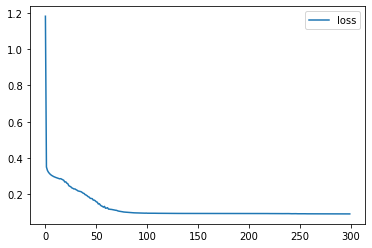

39/39 [==============================] - 1s 16ms/step - loss: 0.0928


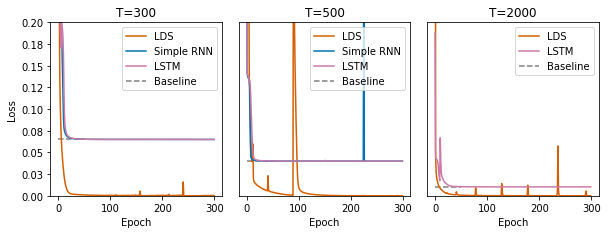

In [ ]:
from matplotlib.ticker import FormatStrFormatter

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(8,3))
fig.subplots_adjust(wspace=-4)
fig.tight_layout()

for j,(ax,T,bound) in enumerate([(ax1, 300, 0.2), (ax2, 500, 0.2), (ax3, 2000, 0.2)]):
  losses = losses352k[j]
  ax.set_yscale('linear')
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  ax.set_ylim(0, bound)
  ax.set_xlabel('Epoch')
  
  if j != 0:
    ax.set_yticks([])
  else:
    ax.set_ylabel('Loss')

  if T == 2000:
    for i, (color, label) in enumerate([((0.835,0.369,0), 'LDS'), ((0.8,0.475,0.655), 'LSTM')]):
      ax.plot(losses[i], color=color, label=label)
  else:
    for i, (color, label) in enumerate([((0.835,0.369,0), 'LDS'), ((0,0.447,0.698), 'Simple RNN'), ((0.8,0.475,0.655), 'LSTM')]):
      ax.plot(losses[i], color=color, label=label)
  ax.hlines(10*np.log(8)/(T+20), 0,50, linestyles='dashed', color='gray', label='Baseline')
  ax.legend()
  ax.set_title('T=' + str(T))

fig.show()
fig.savefig('copyproblem.pdf',  bbox_inches = "tight")


In [ ]:
lds.summary()

Model: "sequential_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
luenberger_stack_32 (Luenber (256, 320, 10)            3460      
Total params: 3,460
Trainable params: 3,380
Non-trainable params: 80
_________________________________________________________________


In [ ]:
np.save('copyinglosses.npy', np.array([losses200, losses300, losses500]))

In [ ]:
losses352k = []
losses235 = np.load('copyinglosses.npy')
losses352k.append(losses235[1])
losses352k.append(losses235[2])
losses352k.append(all_losses)
losses352k = np.array(losses352k)
np.save('copyinglosses_300_500_2000.npy', losses352k)

# Experiment: Adding Problem

In [ ]:
# From https://github.com/batzner/indrnn/blob/master/examples/addition_rnn.py
# Restores normalization of original paper
# Optionally computes polynomial features of the two input features at each timestep
def adding_problem_generator(batch_size=256, time_steps=10):
    """
    A batch generator for the adding problem.
    Code reused from 
    :param batch_size: batch size to use
    :param time_steps: sequence length
    :return: a function for making generators
    """

    def batch():
        while True:
          unif_seq = np.random.rand(batch_size, time_steps)
          indicator_seq = np.zeros((batch_size, time_steps))
          
          half = int(time_steps / 2)
          first_inds = np.random.randint(low=0, high=half, size=batch_size)
          second_inds = np.random.randint(low=half, high=timesteps, size=batch_size)
          indicator_seq[np.arange(batch_size), first_inds] = 1
          indicator_seq[np.arange(batch_size), second_inds] = 1
          
          inputs = np.dstack((unif_seq, indicator_seq))
          targets = unif_seq[np.arange(batch_size), first_inds] + unif_seq[np.arange(batch_size), second_inds]

          yield inputs, targets

    return batch

In [ ]:
from itertools import islice
import json

all_losses = []
class Histories(tf.keras.callbacks.Callback):
  def on_train_begin(self,logs={}):
    self.losses = []

  def on_epoch_end(self, epoch, logs={}):
    self.losses.append(logs.get('loss'))

  def on_train_end(self, logs={}):
    global all_losses
    all_losses.append(self.losses)

Ts = [100, 200, 400, 750]
num_epochss = [80, 80, 120, 180]
lds_learning_rate = 0.003 # 0.01 works
lstm_learning_rate = 0.01
batch_size = 32
steps_per_epoch = 200
num_epochs = 120

# Network Parameters
#timesteps = 100 
n_lds = 32
r=6
n_lstm = 80

srnn = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(n_gru, activation='tanh', kernel_initializer=tf.keras.initializers.Identity),
  tf.keras.layers.Dense(1)
])
srnn_optimizer = tf.keras.optimizers.Adam(lstm_learning_rate)
srnn.build(input_shape=(batch_size, timesteps, 2))
print(srnn.summary())
xx

for timesteps, num_epochs in zip(Ts, num_epochss):
  gen = adding_problem_generator(time_steps=timesteps, batch_size=batch_size)

  history = Histories()
  gru = tf.keras.Sequential([
    tf.compat.v1.keras.layers.CuDNNLSTM(n_lstm, kernel_initializer=tf.keras.initializers.Orthogonal()),
    tf.keras.layers.Dense(1)                           
  ])
  gru_optimizer = tf.keras.optimizers.Adam(lstm_learning_rate)
  gru.build(input_shape=(batch_size, timesteps, 2))
  print(gru.summary())
  print("Learning GRU")
  gru.compile(optimizer=gru_optimizer, loss=tf.keras.losses.mean_squared_error)
  gru.fit(gen(), steps_per_epoch=steps_per_epoch, epochs=num_epochs, callbacks=[history]) 

  history = Histories()
  srnn = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(n_gru, activation='tanh', kernel_initializer=tf.keras.initializers.Identity),
    tf.keras.layers.Dense(1)
  ])
  srnn_optimizer = tf.keras.optimizers.Adam(lstm_learning_rate)
  srnn.build(input_shape=(batch_size, timesteps, 2))
  print(srnn.summary())
  print("Learning SRNN")
  srnn.compile(optimizer=srnn_optimizer, loss=tf.keras.losses.mean_squared_error)
  srnn.fit(gen(), steps_per_epoch=steps_per_epoch, epochs=num_epochs, callbacks=[history])     

  history = Histories()
  lds = tf.keras.Sequential([
    LDStack(n_lds, 1, 2, r=r, AB_param=hinged_AB_param(randroot_λ_init), C_param=standard_C_param(), D_param=standard_D_param(), mode='standard', relaxV=True, last_only=True, 
            ρ=tf.keras.activations.elu)
  ])
  lds.build(input_shape=(batch_size, timesteps, 2))
  lds_optimizer = tf.keras.optimizers.Adamax(lds_learning_rate)
  print(lds.summary())
  print("Learning LDStack")
  lds.compile(optimizer=lds_optimizer, loss=tf.keras.losses.mean_squared_error)
  lds.fit(gen(), steps_per_epoch=steps_per_epoch, epochs=num_epochs, callbacks=[history])

print(json.dumps(all_losses))

## Experiment: Sequential Permuted MNIST


In [ ]:
import json
#all_losses = []
class Histories(tf.keras.callbacks.Callback):
  def on_train_begin(self,logs={}):
    self.losses = []

  def on_epoch_end(self, epoch, logs={}):
    self.losses.append(logs.get('val_sparse_categorical_accuracy'))

  def on_train_end(self, logs={}):
    global all_losses
    all_losses.append(self.losses)

lds_learning_rate = 0.0003
lstm_learning_rate = 0.01
batch_size = 128
num_epochs = 50

# Network Parameters
num_channels = 1 
timesteps = 28 * 28 
n_lds = 384
n_lstm = 128
num_classes = 10 
k = 1
Delta = 1
num_stacks = 1

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, timesteps, num_channels).astype(np.float32)/255
x_test  = x_test.reshape(-1, timesteps, num_channels).astype(np.float32)/255
y_train = y_train.astype(np.int64)
y_test  = y_test.astype(np.int64)

#permute = np.random.permutation(timesteps)
permute = [ 82, 522, 476, 588, 115, 425, 121, 458, 777, 563, 218, 282, 213,
       782, 708, 682, 741, 515, 340, 767, 326, 283, 461, 207, 532, 689,
       778, 189, 743, 433, 496, 351, 333, 323, 597, 625, 652, 394, 494,
       239, 602,  47, 617,  93, 367, 258, 759,   2, 384, 499, 186, 415,
       396, 336, 766, 775, 419, 361, 181, 637, 572,  27, 771, 464, 680,
       635, 156, 163, 201, 254,  66, 483, 388,  60, 445,  59, 607, 508,
       735, 619, 505, 233, 740, 353, 184, 512,  20, 727, 526, 480, 704,
       584, 468,  32, 211, 548, 160, 582, 501, 242, 148, 393, 482, 214,
       370, 176, 779, 400, 100, 182, 507, 378,  98, 714, 484, 783, 441,
       161, 734, 678, 408, 762, 477, 552, 725, 636, 730, 151, 202, 596,
       249, 448, 430, 247, 375, 398, 489, 385, 567, 271, 459, 773, 493,
       537,  42, 127, 328, 611, 610, 465, 550,  73, 135, 706, 648, 590,
       416, 620, 674, 669,  25, 520, 574,  29, 538, 141, 399, 633, 316,
        37,  85, 702, 495, 146, 102, 546, 355, 130, 618,  19,   3, 311,
       738, 650, 679, 586, 761, 555, 293, 180, 456, 756, 152,  87, 664,
        74, 170, 209,  12, 159, 514, 713, 158, 641, 221, 380, 193, 723,
       752, 315,   4, 694, 466, 677, 290, 372, 568, 369,  88, 638, 578,
       690,  57, 349, 523,  35, 686, 435, 534, 431, 744, 724, 379, 627,
       360, 325, 549,  23, 318, 565, 630, 169, 154, 616, 569, 580, 592,
       753,  71, 750, 274, 428, 442, 421, 511, 406, 265, 300, 266, 120,
       623, 261, 364, 509,  55,  72, 391, 776, 687, 497, 299, 371, 373,
       276, 675, 362, 481, 417, 737, 106, 561, 123, 125, 192, 194,  76,
       341, 684, 197, 490, 252, 594, 749, 599, 447,  52,  89, 573, 278,
        44, 251, 488, 774, 717, 137, 386, 649, 646,  45, 666, 206, 365,
        99, 376,  69,  10,  31, 608,  43, 277, 657, 685, 157, 457, 644,
       131, 576,  77, 195, 203, 183, 128, 440, 188, 437, 429, 544,  65,
       647, 726, 658, 101, 424, 693, 306, 570, 539, 654, 462, 598, 269,
       583, 469,   8, 671,  58, 309, 256, 108, 220, 410, 688, 681, 463,
       264, 470, 405, 707,  70, 475, 352, 173, 304, 297, 764,  48, 600,
       472, 709, 332, 757, 517, 331, 143, 547,   5, 164, 260, 136, 524,
       346, 199, 224, 329, 710, 712,  30, 587, 535, 301, 155, 402, 655,
        24, 245,  15, 781, 642, 446, 228, 591, 699, 559, 491, 605, 603,
       645,  18, 701, 279, 132,  50,  53, 229, 111, 479, 554, 718,  67,
       473, 566, 609, 667, 438, 133, 322, 739, 579, 613, 747, 736, 722,
       662, 289, 174, 147, 310, 363, 138, 105, 267, 145, 696, 175, 656,
       409, 324, 705, 577, 124, 763, 454, 392, 516, 162,  61, 116, 345,
       506, 390, 504, 525, 187, 150, 615, 395, 760, 313, 382, 670, 284,
       411, 668, 450, 225, 426, 443, 665, 292, 436, 212, 401, 240, 126,
       165, 272, 651, 492,  26, 381, 296,  33, 356, 404, 745, 337, 216,
       140, 474, 663, 222,   9, 320, 219, 139, 553, 303, 235, 397, 377,
       510,  94, 236, 359, 422,  96, 166, 498, 606,  80, 241, 711, 581,
       347, 672, 632, 344, 196, 179, 215, 403,  40, 334, 683, 660,  13,
       414, 715,   7,  22, 528, 780, 295, 503,  68, 695,  41, 319, 246,
       769, 109, 628,  56, 339, 639, 716, 413, 250, 643, 275, 755, 746,
       467, 330, 640, 595, 455,  34, 348, 374, 354, 153, 700, 302, 317,
       453, 765,   0, 118, 327, 770, 731, 614, 321, 530, 387, 167, 407,
       149, 178, 217, 208, 471, 190, 518,  79, 659, 291, 703, 232, 585,
       527, 205, 307, 575, 168, 287, 622, 720,  95, 389, 234, 540,  36,
       288, 281,  14, 629, 312, 729, 231, 543,  84,  17, 449, 172, 542,
       357, 691, 733,  62, 238, 533, 719,  28,  21,  64, 259, 273, 314,
        86, 200, 263, 122, 185, 557, 253, 210, 754, 772, 134,  16, 305,
       485, 342, 661, 541, 556, 529, 721,  63, 500, 257,  54,  75, 412,
       262,  46, 768, 732, 420, 571, 558, 308, 423, 551, 104, 103, 487,
       230, 751, 728, 226, 280, 171, 452, 366, 112, 531, 758,  92, 460,
       432, 298, 383,   6, 237,  38, 368,  51, 676, 142, 286, 177, 502,
       350, 204, 338, 107, 268, 521,  91, 294, 560, 114,  83, 621, 117,
       418, 478, 451,   1, 285, 589, 562, 631, 358, 110, 626, 191,  78,
        49, 227, 545, 513, 612, 519, 601, 198, 697, 742, 593, 564,  11,
       692, 243, 439, 335, 673,  39, 223, 444, 698, 244, 748, 248,  81,
       270, 144, 119, 255, 129, 427, 624,  90, 634,  97, 604, 113, 536,
       653, 434, 486, 343]
x_train = x_train[:,permute,:]
x_test = x_test[:,permute,:]

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(3000).batch(batch_size, drop_remainder=True)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size, drop_remainder=True)


#
# Simple RNN
#
history = Histories()
srnn = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(128, activation='tanh'),                           
  tf.keras.layers.Dense(num_classes)                           
])
srnn_optimizer = tf.keras.optimizers.Adam(lstm_learning_rate)
srnn.build(input_shape=(batch_size, timesteps, num_channels))
print(srnn.summary())

print("Learning Simple RNN")
srnn.compile(optimizer=srnn_optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
srnn.fit(train_dataset, batch_size=batch_size, epochs=num_epochs, validation_data=test_dataset, callbacks=[history])

#
# LSTM
#
history = Histories()
gru = tf.keras.Sequential([
  tf.compat.v1.keras.layers.CuDNNLSTM(n_lstm, kernel_initializer=tf.keras.initializers.Orthogonal()),
  tf.keras.layers.Dense(num_classes)                           
])
gru_optimizer = tf.keras.optimizers.Adamax(lstm_learning_rate)
gru.build(input_shape=(batch_size, timesteps, 1))
print(gru.summary())
print("Learning LSTM")
gru.compile(optimizer=gru_optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
gru.fit(train_dataset, batch_size=batch_size, epochs=num_epochs, validation_data=test_dataset, callbacks=[history])


#
# Plain LDS
#

history = Histories()
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=2)
lds = tf.keras.Sequential([
#  tf.keras.layers.Conv1D(1, 5, padding='same', activation='elu', kernel_initializer=tf.keras.initializers.GlorotNormal),
  SparseLDS(timesteps, num_classes, 
          AB_param=hinged_AB_param(randroot_λ_init), 
          C_param=relaxed_log_C_param(0.1), 
          D_param=standard_D_param(useD=True))
])
lds.build((batch_size, timesteps, num_channels))
lds_optimizer = tf.keras.optimizers.Adamax(lds_learning_rate)
print(lds.summary())

print("Learning Plain LDS")
lds.compile(optimizer=lds_optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
lds.fit(train_dataset, batch_size=batch_size, epochs=num_epochs, validation_data=test_dataset, callbacks=[history, reduce_lr])




print(json.dumps(all_losses))

#
# LDStack
#

#AB_param=log_polar_AB_param(ln_r_init=tf.keras.initializers.RandomUniform(minval=-1,maxval=0))
#AB_param = hinged_AB_param(randroot_λ_init)
AB_param = unitary_AB_param()

lds = tf.keras.Sequential([
    #tf.keras.layers.Dense(1, use_bias=False, kernel_initializer=tf.keras.initializers.Constant(0.1)),
    LDStack(n_lds, num_classes, Δ=2, AB_param=AB_param, 
            mode='naive',
            C_param=relaxed_log_C_param(0.1),#standard_C_param(0.1), 
            D_param=standard_D_param(), 
                    last_only=True, 
                    W_init=tf.keras.initializers.Identity(),
                    #𝒯_init=lambda n: random_controllability_matrix(n),
                    r=1),
    #tf.keras.layers.Activation('tanh'),
    #tf.keras.layers.Dense(num_classes)#, kernel_initializer=tf.keras.initializers.Identity())
#    ProjectionStack(n_lds, m, Δ=Δ, k=1, AB_param=AB_param, C_param=standard_C_param(0.01), D_param=standard_D_param(), ρ=nonlin),
  ])
lds.build((batch_size, timesteps, num_channels))
lds_optimizer = tf.keras.optimizers.Adam(lds_learning_rate)
print(lds.summary())

print("Learning LDStack")
lds.compile(optimizer=lds_optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
lds.fit(train_dataset, batch_size=batch_size, epochs=num_epochs, validation_data=test_dataset)

for epoch in np.arange(num_epochs):    
  for step, (batch_x, batch_y) in enumerate(train_dataset):
    with tf.GradientTape() as tape:
      lds_logits = lds(batch_x)
      lds_loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)(batch_y, lds_logits)
    grads = tape.gradient(lds_loss, lds.trainable_variables)
    print([v.name + ": " + str(tf.linalg.norm(g).numpy()) if g is not None else '' for g,v in zip(grads, lds.trainable_variables)])
    capped_grads, _ = tf.clip_by_global_norm(grads, 1.)
    lds_optimizer.apply_gradients(zip(capped_grads, lds.trainable_variables))

    print(lds_loss.numpy())

In [ ]:
all_losses.append(history.losses)